In [2]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(MASS)) install.packages('MASS')
library('MASS')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
if (!require(tidyr)) install.packages('tidyr')
library('tidyr')
library('IRdisplay')

n_cores <- detectCores()
cluster <- makeCluster(14) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

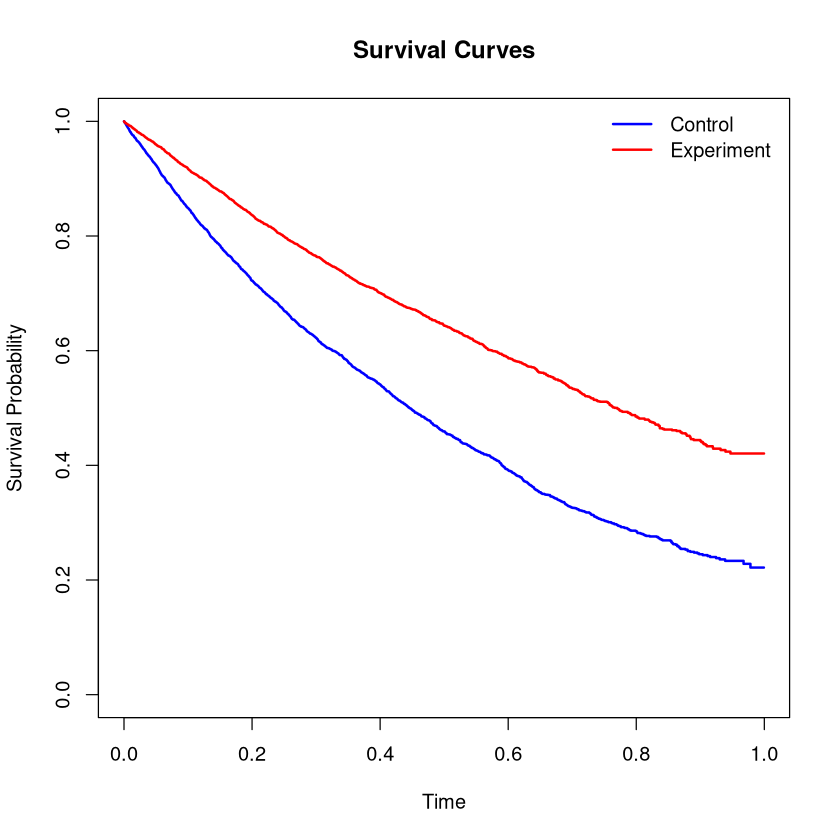

In [36]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4923799 
Variance of RMST estimation of Control arm is: 1.212278e-05 
RMST of Experiment arm is: 0.6585054 
Variance of RMST estimation of Experiment arm is: 1.264252e-05

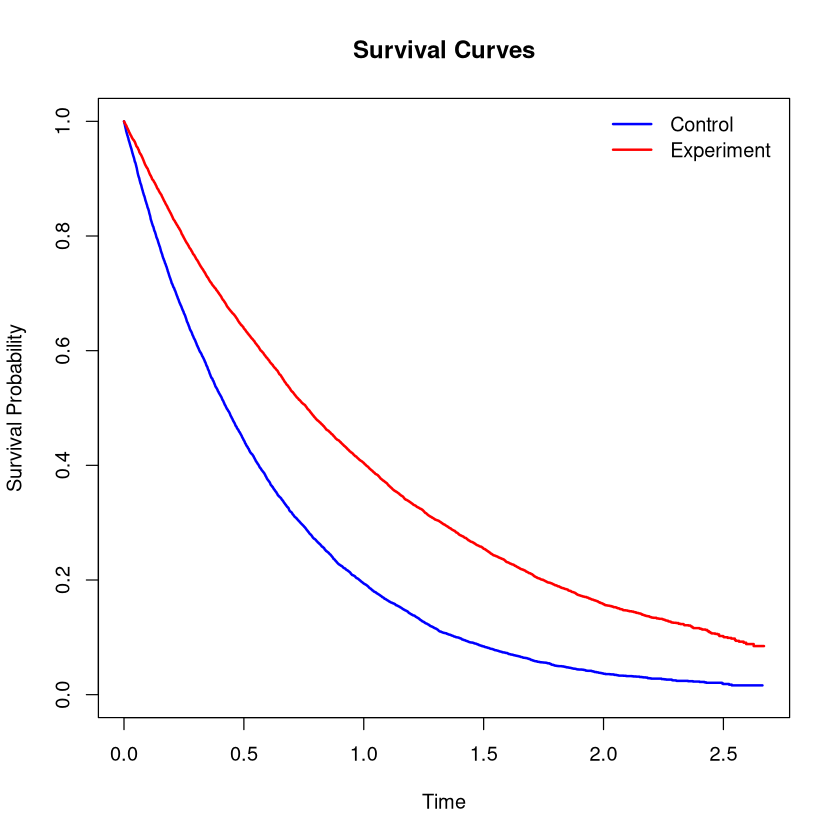

In [37]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$


In [ ]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 
### <span style="color:yellow"> I am trying to reproduce the result in Jung(2017) by grid searching 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

In [ ]:
z_stats_h0_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H0_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C_int, data_E = data_E_H1_int, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)
logrank_data 

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.9991,result.9992,result.9993,result.9994,result.9995,result.9996,result.9997,result.9998,result.9999,result.10000
z_stats_h0_int,-1.2872474,1.112123,-2.1856323,-0.4871775,0.3551447,0.2459673,1.6505821,0.2404881,-0.6236618,-0.6377972,⋯,0.4123125,1.4529391,1.1189202,-0.3584861,-0.9876944,-0.3656003,1.117835,-0.19184269,0.2899575,0.3219920
z_stats_h1_int,1.6470271,3.168536,-0.9422678,1.3230336,0.7968894,2.4742329,2.9627174,0.2666048,0.5181259,1.6724925,⋯,2.2976298,0.5973465,2.3315186,0.8112787,2.3312606,0.1724213,1.105871,1.32263295,1.0234962,2.2295654
z_stats_h0_fin,-0.6928428,-1.068716,-2.8305862,0.3613341,1.2141556,1.7793817,0.7754382,0.8505837,0.7242671,0.2193938,⋯,0.5205964,0.9144868,0.4587114,1.2737350,-1.1215383,-1.3841143,2.033960,-0.05981692,0.3443267,0.3460273
z_stats_h1_fin,2.0152389,2.221934,1.0692737,3.3243011,2.8097983,4.8082256,4.3281383,3.4476979,3.2569595,2.2602944,⋯,3.5399141,2.4835404,2.8392669,3.0335143,1.3214492,0.2049053,2.928037,3.08091001,1.9971216,2.0482152


In [ ]:
find_m_logrank(m_low = -3, logrank_data = logrank_data, search_times = 5000, search_step = 0.001,
                tar_a1 = 0.8, tar_pow1_low = 0.1, tar_a2 = 0.1, sim_size = 10000)

m1,PET0,PET1,m2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.844,0.2001,0.0127,1.274,0.0998,0.9046


### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is almost the same as 2 stages log rank design


In [ ]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

### Some experiments in Jung 2017 p650 table 1. Stop for futility only.
#### Optimal: $\lambda_2=0.9,\lambda_1 = \lambda_2*\Delta,n = 187, n_1 = 95, \alpha = 0.05, 1-\beta = 0.8$
#### $PET_0 = 0.556, PET_1 = 0.104$

In [ ]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174/2)  #sample size per arm 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)                             

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)


### Use the cut off point in Jung's paper

In [ ]:
m1 <- -0.32
m2 <- 1.641
#PET0
1 - sum(z_stats_h0_int > m1)/sim_size
#PET1
1 - sum(z_stats_h1_int > m1)/sim_size
#alpha
sum((logrank_data[1, ] > m1) & (logrank_data[3, ]  > m2))/sim_size
#power 
sum((logrank_data[2, ] > m1) & (logrank_data[4, ]  > m2))/sim_size

[1] 0.3803

[1] 0.0277

[1] 0.0501

[1] 0.7988

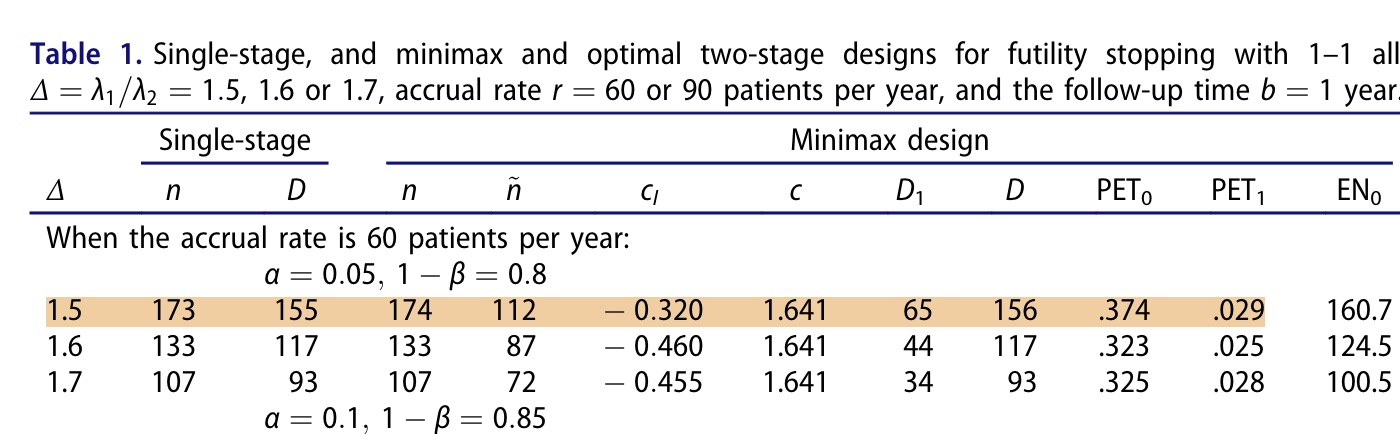

In [ ]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

### Use my searching loop

In [ ]:
find_m_logrank(m_low = -2, logrank_data = logrank_data, search_times = 5000, search_step = 0.001,
                tar_a1 = 0.62, tar_pow1_low = 0, tar_a2 = 0.05, sim_size = 10000)

m1,PET0,PET1,m2,alpha,Power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.32,0.3803,0.0277,1.643,0.0499,0.7983


#### Under PH, we can find a proper critical value to make 2 stages power ~ single stage 
#### This conclusion is true when stopping for both superiority and futility or for futility only.
#### overall $\textcolor{lightgreen}{\alpha = P(\frac{W_1}{\sigma_1}>C_u|H_0) + P(C_l<\frac{W_1}{\sigma_1}<C_u,\frac{W}{\sigma}>C|H_0)}$
-------

# Our Rejection Region
### <span style="color:yellow">E and C are the RMST value of experiment group and control group respectively
### subscript 1 means interim period, 2 for final period
#### Stage I : process to stage II (reject $H_0$) when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$, where $m_1>0$
### Stage II:
#### reject $H_0$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2},\ $  $m_1, m_2 >0$


### By the asymptotic normality of RMST:
$$
 \textcolor{lightgreen}{[E1-C1,\ E1,\ E2-C2,\ E2] \sim \mathcal{N}\ (\ \hat{\mu},\ \hat{\Sigma}\ )}
$$

$$
\hat{\Sigma} = 
 \left[
 \begin{matrix}
   Var(E1)+Var(C1) & Var(E1) & Cov(E1,E2)+Cov(C1,C2) & Cov(E1,E2) \\
                   & Var(E1) & Cov(E1,E2) & Cov(E1,E2) \\
                   &         & Var(E2)+Var(C2) & Var(E2)\\
                   &         &                 & Var(E2)\\
  \end{matrix}
\right]
$$

## Monte Carlo
$ var[\widehat{RMST_{E1}}]=\frac{1}{B}\sum\limits_{i = 1}^{B} (\widehat{RMST_{E1,i}} - \bar{RMST_{E1}})^2$

Similar to Lu(2021) 

$$
 \left[
 \begin{matrix}
   Var(\hat{E1}) & Cov(\hat{E1}, \hat{E2}) \\
   Cov(\hat{E1}, \hat{E2}) & Var{\hat{E2}} \\
  \end{matrix}
  \right] = 

\frac{1}{B}\sum\limits_{i = 1}^{B} 
 \left[
 \begin{matrix}
   \widehat{RMST_{E1}} - \bar{RMST_{E1}} \\
   \widehat{RMST_{E2}} - \bar{RMST_{E2}} \\
  \end{matrix}
  \right] ^{\bigotimes2}_i 
$$

$ \bar{RMST_{E1}} = \frac{1}{B}\sum^{B}_{i = 1}RMST_{E1,i}$ is the mean RMST value of simulation
#### <span style="color:yellow">Use the setting of Jung 2017 table 1 first row (Minimax)




In [32]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174 / 2)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

rmst_int_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_fin_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                                 
rmst_int_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_fin_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_int_h0, rmst_fin = rmst_fin_h0, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_int_h1, rmst_fin = rmst_fin_h1, sim_size = sim_size)
cat('----------------- Under H0 -----------------')
mu_cov_h0$mu
mu_cov_h0$sigma
cat('----------------- Under H1 -----------------')
mu_cov_h1$mu
mu_cov_h1$sigma

----------------- Under H0 -----------------

[1] -0.0009244598  0.6437030906 -0.0008266902  0.7209832338

0.013347573,0.006682451,0.007468517,0.003756487
0.006682451,0.006682451,0.003756487,0.003756487
0.007468517,0.003756487,0.011432684,0.005749263
0.003756487,0.003756487,0.005749263,0.005749263


----------------- Under H1 -----------------

[1] 0.1872043 0.8355180 0.3104179 1.0345292

0.016176574,0.009440102,0.009336402,0.005552532
0.009440102,0.009440102,0.005552532,0.005552532
0.009336402,0.005552532,0.017116352,0.011343458
0.005552532,0.005552532,0.011343458,0.011343458


#### The mean and cov estimation shown above are packed in function 'mu_cov_mc'
#### The Estimation of $\mu\ and\ \Sigma | H_0,\ H_1$ are shown above 

------

# <span style="color:yellow">  Parameter Optimization (Grid Search)
Reference: Zhou(2017) BOP2 Bayesian design. DOI:10.1002/sim.7338

#### In order to solve the critical values ($m_1,\ t_1,\ m_2,\ t_2$), a function that can control the normal probability is required. The following $\mathcal{f}(n)$  is what we proposed.
$$
\Large \mathcal{f}(n) = \mathcal{e}^{-\ \gamma · \frac{n}{N}}
$$
#### $n$ is the sample size(2 arms) of interim period. $N$ is the final total sample size of 2 arms. 
#### Then we set the following constraints:
$$
\begin{aligned}
\large P(E_1 - C_1 > m_1) &= \mathcal{f}(n)  \\
\large P(E_1 - C_1 > m_1\ \&\ E_1 > t_1) &= \lambda · \mathcal{f}(n) \\
\large P(E_2 - C_2 > m_2) &=  \mathcal{f}(N) \\
\large P(E_2 - C_2 > m_2\ \&\ E_2 > t_2) &= \lambda · \mathcal{f}(N) \\
0<\lambda<1,\ \gamma>0
\end{aligned}
$$

#### $ \mathcal{f}(n)$ is a monotonously decereasing funciton of n, which means that two probability constraints in interim period will go up when the interim sample size n decrease. <span style="color:yellow"> It leads to a small early stop probability with an insufficient interim sample size.  
#### Then we grid search $(\lambda, \gamma)$ . Each pair of $(\lambda, \gamma)$ determines a set of ($m_1,\ t_1,\ m_2,\ t_2$) by normal calculation. Record critical values sets that yield the desirable overall type I error $\alpha$:
$$
\large P(E_1-C_1>m_1\ \&\  E_1>t_1\ \&\  E_2 - C_2>m_2\ \&\  E_2>t_2\ |H_0) < \alpha
$$
#### Find the most powerful one under $H_1$ among these ($m_1,\ t_1,\ m_2,\ t_2$)

In [33]:
n <- 112     #interim sample size
N <- 174    #overall sample size
alpha <- 0.05

# Interim
mu1 <- mu_cov_h1$mu[c(1,2)]
Sigma1 <- mu_cov_h1$sigma[1:2, 1:2]
# Final
mu2 <- mu_cov_h1$mu[c(3,4)]
Sigma2 <- mu_cov_h1$sigma[3:4, 3:4]

# Function to minimize solve t in P(E-C > m & E > t) = tar_prob given m
norm_2d <- function(t, m, mean, sigma, tar_prob) 
  {
    prob <- pmvnorm(lower = c(m, t), 
                    upper = rep(Inf, 2), 
                    mean = mean, 
                    sigma = sigma)
    return (prob - tar_prob)
  }

#Grid search
crit_val_res <- foreach(lambda = seq(0.01, 0.99, 0.01), .combine = 'cbind') %dopar%
  {   
    best_gamma <- c()
    best_power <- 0
    for (gamma in seq(0, 1, by = 0.01))
      {
        p1_tar <- exp(-gamma * (n/N))            # P(E1-C1 > m1)
        p2_tar <- lambda * exp(-gamma * (n/N))   # P(E1-C1 > m1, E1 > t1)
        p3_tar <- exp(-gamma * (N/N))            # P(E2-C2 > m2)
        p4_tar <- lambda * exp(-gamma * (N/N))   # P(E2-C2 > m2, E2 > t2)

        # First equation P(E1-C1 > m1) = p1_tar
        m1 <- qnorm(1 - p1_tar, mean = mu1[1], sd = sqrt(Sigma1[1, 1]))
        # Second equation P(E1-C1 > m1 & E1 > t1) = p2_tar
        t1 <- uniroot(norm_2d, interval = c(0, 100), m = m1, 
                      mean = mu1, sigma = Sigma1, tar_prob = p2_tar)$root
        # Third equation
        m2 <- qnorm(1 - p3_tar, mean = mu2[1], sd = sqrt(Sigma2[1, 1])) 
        # Forth equation
        t2 <- uniroot(norm_2d, interval = c(0, 100), m = m2, 
                      mean = mu2, sigma = Sigma2, tar_prob = p4_tar)$root

        proc_h0 <- sum((rmst_int_h0[2, ] - rmst_int_h0[1, ] > m1) & (rmst_int_h0[2, ] > t1) &
                      (rmst_fin_h0[2, ] - rmst_fin_h0[1, ] > m2) & (rmst_fin_h0[2, ] > t2))
        proc_h1 <- sum((rmst_int_h1[2, ] - rmst_int_h1[1, ] > m1) & (rmst_int_h1[2, ] > t1) &
                      (rmst_fin_h1[2, ] - rmst_fin_h1[1, ] > m2) & (rmst_fin_h1[2, ] > t2))

        if (m1 > 0 & m2 > 0 & proc_h0 / sim_size <= alpha 
            & proc_h1 / sim_size > best_power)  #control alpha, find the most powerful set
          {
            best_power <- proc_h1 / sim_size
            best_gamma <- c(m1, t1, m2, t2, lambda, gamma, proc_h0/sim_size, proc_h1/sim_size)
          }
      }
    best_gamma 
    }


In [34]:
crit_val_res <- data.frame(crit_val_res)
rownames(crit_val_res) <- c('m1', 't1', 'm2', 't2', 'lambda', 'gamma', 'alpha', "power")
crit_val_res

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,⋯,result.90,result.91,result.92,result.93,result.94,result.95,result.96,result.97,result.98,result.99
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,⋯,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595,0.003513595
t1,1.064351909,1.038138225,1.021540990,1.009068980,0.998933273,0.990313233,0.982762177,0.976027455,0.969881004,0.964288728,⋯,0.732648541,0.727763547,0.722473006,0.716721779,0.710301468,0.703042313,0.694575895,0.684289200,0.670726606,0.649722881
m2,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,⋯,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421,0.152073421
t2,1.287056475,1.258496952,1.240422579,1.226829057,1.215816381,1.206486968,1.198275820,1.190957703,1.184280283,1.178192282,⋯,0.933771514,0.928855386,0.923514704,0.917704966,0.911237555,0.903949058,0.895464157,0.885148428,0.871661762,0.850767709
lambda,0.010000000,0.020000000,0.030000000,0.040000000,0.050000000,0.060000000,0.070000000,0.080000000,0.090000000,0.100000000,⋯,0.900000000,0.910000000,0.920000000,0.930000000,0.940000000,0.950000000,0.960000000,0.970000000,0.980000000,0.990000000
gamma,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,⋯,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000,0.120000000
alpha,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,⋯,0.002900000,0.003100000,0.003300000,0.003800000,0.004600000,0.005900000,0.007000000,0.009800000,0.014800000,0.022800000
power,0.001600000,0.003500000,0.005800000,0.008100000,0.011300000,0.014800000,0.018700000,0.022200000,0.027100000,0.031400000,⋯,0.710900000,0.724100000,0.736500000,0.751400000,0.767300000,0.783100000,0.795900000,0.813800000,0.829000000,0.846800000


### Use the normality of 4d RMST to calculate the Type I error and Power
### * The alpha and power calculated in the function above is based on the simulated survival data

In [35]:
best_res <- crit_val_res[, which(crit_val_res[8, ] == max(crit_val_res[8, ]))]
best_res
threshold <- best_res[1:4]
# Monte Carlo normal probability 
norm_sam_h0 <- mvrnorm(100000, mu = mu_cov_h0$mu, Sigma = mu_cov_h0$sigma)
norm_sam_h1 <- mvrnorm(100000, mu = mu_cov_h1$mu, Sigma = mu_cov_h1$sigma)

cat('The type one error is:',sum(apply(norm_sam_h0, 1, function(x) all(x > threshold))) / 100000, '\n')
cat('The Power is:',sum(apply(norm_sam_h1, 1, function(x) all(x > threshold))) / 100000, '\n')
cat('PET0 is:', sum((rmst_int_h0[2, ] - rmst_int_h0[1, ] < best_res[1]) | (rmst_int_h0[2, ] < best_res[2]))/sim_size, '\n')
cat('PET1 is:', sum((rmst_int_h1[2, ] - rmst_int_h1[1, ] < best_res[1]) | (rmst_int_h1[2, ] < best_res[2]))/sim_size, '\n')


[1] 0.003513595 0.649722881 0.152073421 0.850767709 0.990000000 0.120000000
[7] 0.022800000 0.846800000

The type one error is: 0.02071 
The Power is: 0.83078 
PET0 is: 0.6613 
PET1 is: 0.0731 


### <span style="color:yellow">  The power is slightly higher than LR but cost should be global robustness (Litwin 2017)  
### The grid searching procedure above is packed in function: 'adp_grid_src'
------


## Global Robustness
#### Litwin mentioned that when the real distribution parameters vary from the stated ones, the alpha under the same critical values will increase sharply. This method will sacrify globally robustness.
### <span style="color:yellow"> Compare the robustness between LR test and Our method when Hazard Ratio change
#### $\lambda_E| H_1 = 0.9,\ \lambda_C/\lambda_E = 1.5$ Follow Jung 2017 table1

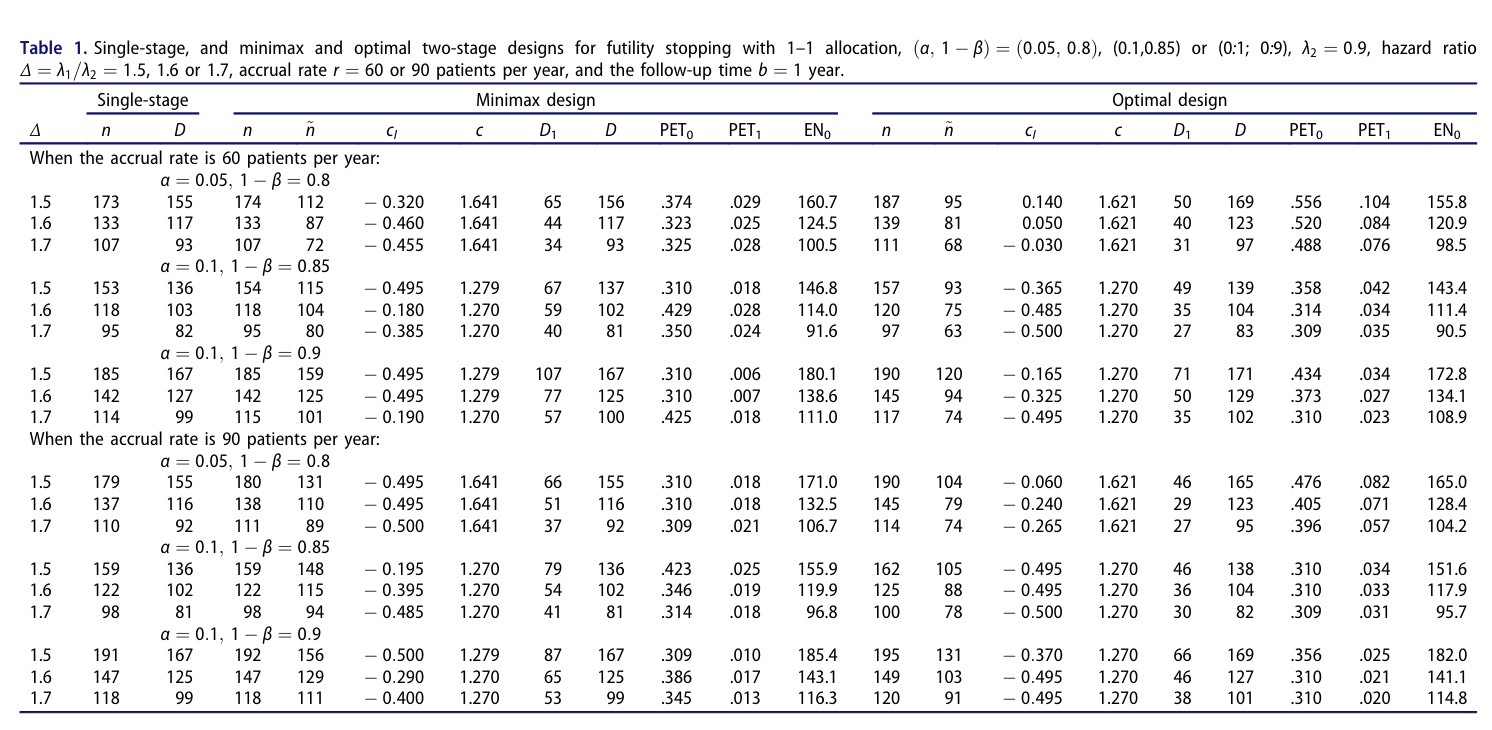

In [30]:
display_jpeg(file='figures/Jung2017_full_table1.jpeg')

In [49]:
sim_size <- 10000
r <- 90
acc_time <- 162 / r
cen_time <- 1
interim <- 105 / r
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
n <- ceiling(162 / 2)  #per arm
alpha <- 0.1

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

rmst_int_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_fin_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
rmst_int_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_fin_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_int_h0, rmst_fin = rmst_fin_h0, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_int_h1, rmst_fin = rmst_fin_h1, sim_size = sim_size)

best_res <- adp_grid_src(rmst_int_h0 = rmst_int_h0, rmst_fin_h0 = rmst_fin_h0, rmst_int_h1 = rmst_int_h1, 
                rmst_fin_h1 = rmst_fin_h1, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, sim_size = sim_size) 

### Under the same critical value(cutoff) and all other setting, Change $\lambda_C/\lambda_E$

In [50]:
m1 <- as.numeric(best_res[1])
t1 <- as.numeric(best_res[2])
m2 <- as.numeric(best_res[3])
t2 <- as.numeric(best_res[4])

# Critical value of LR
cl <- -0.495
c <- 1.27

diff_LR <- foreach(LR = seq(1.3, 1.7, by = 0.05), .combine = 'cbind') %dopar%
{
    lambda_H0 <- 0.9 * LR
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

    rmst_int_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_fin_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_int_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_fin_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > cl & z_stats_h0_fin > c) / sim_size
    power_lr <- sum(z_stats_h1_int > cl & z_stats_h1_fin > c) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= cl) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= cl) / sim_size
    a_our <- sum((rmst_int_h0[2, ] - rmst_int_h0[1, ] > m1) & (rmst_int_h0[2, ] > t1) &
                (rmst_fin_h0[2, ] - rmst_fin_h0[1, ] > m2) & (rmst_fin_h0[2, ] > t2)) / sim_size
    power_our <- sum((rmst_int_h1[2, ] - rmst_int_h1[1, ] > m1) & (rmst_int_h1[2, ] > t1) &
                    (rmst_fin_h1[2, ] - rmst_fin_h1[1, ] > m2) & (rmst_fin_h1[2, ] > t2)) / sim_size
    pet0_our <- sum((rmst_int_h0[2, ] - rmst_int_h0[1, ] <= m1) | (rmst_int_h0[2, ] <= t1)) / sim_size
    pet1_our <- sum((rmst_int_h1[2, ] - rmst_int_h1[1, ] <= m1) | (rmst_int_h1[2, ] <= t1)) / sim_size
   
    return(c(LR, a_lr, power_lr, a_our, power_our, pet0_lr, pet1_lr, pet0_our, pet1_our))
}


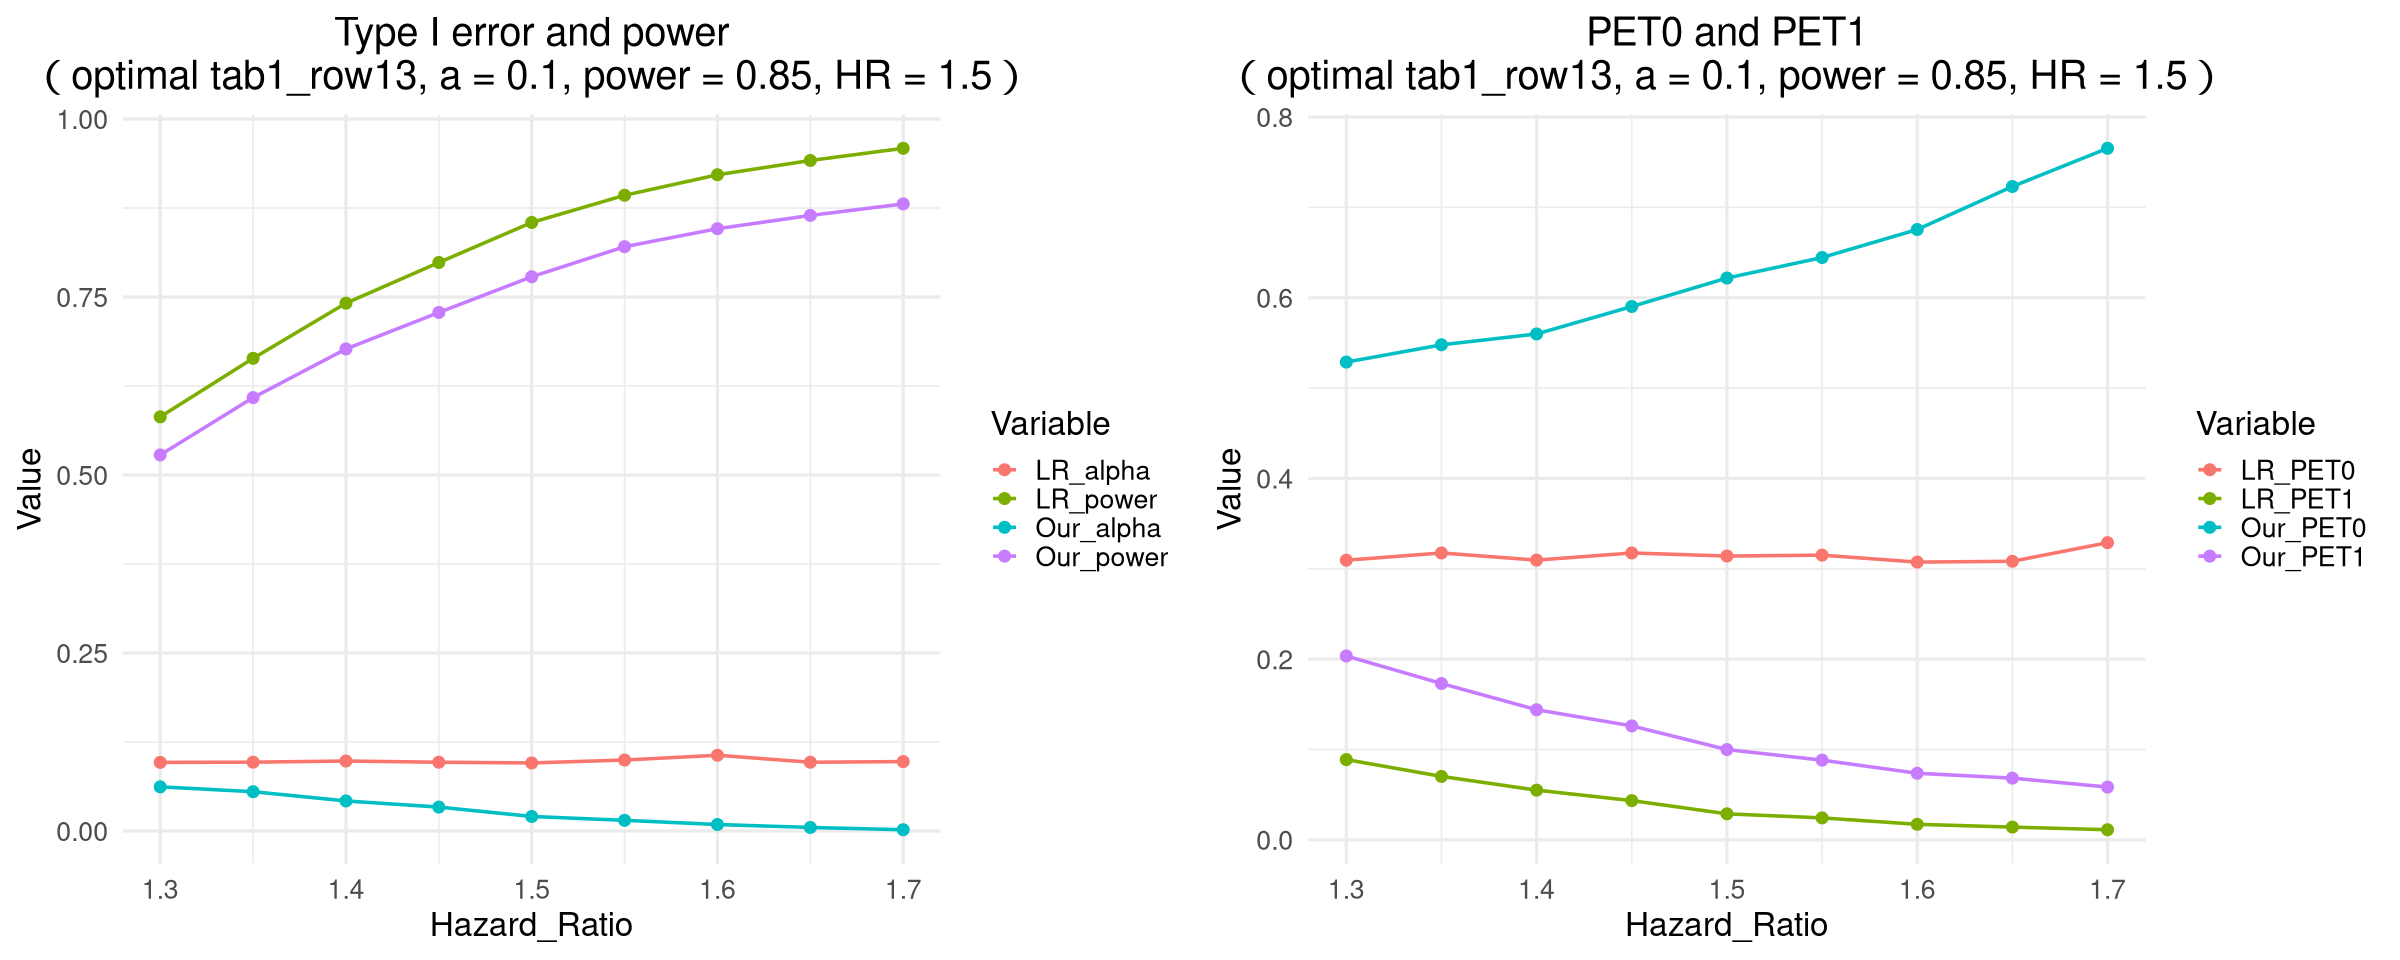

In [52]:
options(repr.plot.width = 20, repr.plot.height = 8)

a_power_df <- data.frame(t(diff_LR[1:5, ]))
colnames(a_power_df) <- c('Hazard_Ratio','LR_alpha','LR_power','Our_alpha','Our_power')
a_power_long <- a_power_df %>%
  pivot_longer(cols = -Hazard_Ratio, names_to = "variable", values_to = "value")
plot1 <- ggplot(a_power_long, aes(x = Hazard_Ratio, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Hazard_Ratio", y = "Value", color = "Variable",
      title = 'Type I error and power\n（optimal tab1_row13, a = 0.1, power = 0.85, HR = 1.5）') +
  theme_minimal(base_size = 20) + 
  theme(plot.title = element_text(hjust = 0.5))

pet_df <- data.frame(t(diff_LR[c(1,6,7,8,9), ]))
colnames(pet_df) <- c('Hazard_Ratio','LR_PET0','LR_PET1','Our_PET0','Our_PET1')
pet_long <- pet_df %>%
  pivot_longer(cols = -Hazard_Ratio, names_to = "variable", values_to = "value")
plot2 <- ggplot(pet_long, aes(x = Hazard_Ratio, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Hazard_Ratio", y = "Value", color = "Variable",
      title = 'PET0 and PET1\n（optimal tab1_row13, a = 0.1, power = 0.85, HR = 1.5）') +
  theme_minimal(base_size = 20) + 
  theme(plot.title = element_text(hjust = 0.5))

plot_grid(plot1, plot2, ncol = 2)

----
# Test for different Interim Period

### Different Interim $\textcolor{yellow}{\tau}$
### 0.083 year is around a month. From 7 months interim to 16 months.

m1,t1,PET0,PET1,m2,t2,alpha,Power,interim_month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.01,0.1900000,0.5596,0.2406,0.01,0.6700000,0.0892,0.7548,7
0.01,0.2366667,0.5518,0.1999,0.01,0.6666667,0.0960,0.7962,8
0.01,0.2800000,0.5509,0.1705,0.01,0.6733333,0.0949,0.8261,9
0.01,0.2533333,0.5395,0.1462,0.01,0.6766667,0.0976,0.8487,10
0.01,0.2800000,0.5385,0.1215,0.02,0.6766667,0.0988,0.8735,11
0.01,0.3400000,0.5498,0.1016,0.01,0.6766667,0.0982,0.8930,12
0.01,0.3666667,0.5497,0.0857,0.01,0.6800000,0.0982,0.9079,13
0.01,0.3933333,0.5465,0.0652,0.01,0.6766667,0.0988,0.9288,14
0.01,0.4100000,0.5491,0.0552,0.01,0.6800000,0.0993,0.9388,15


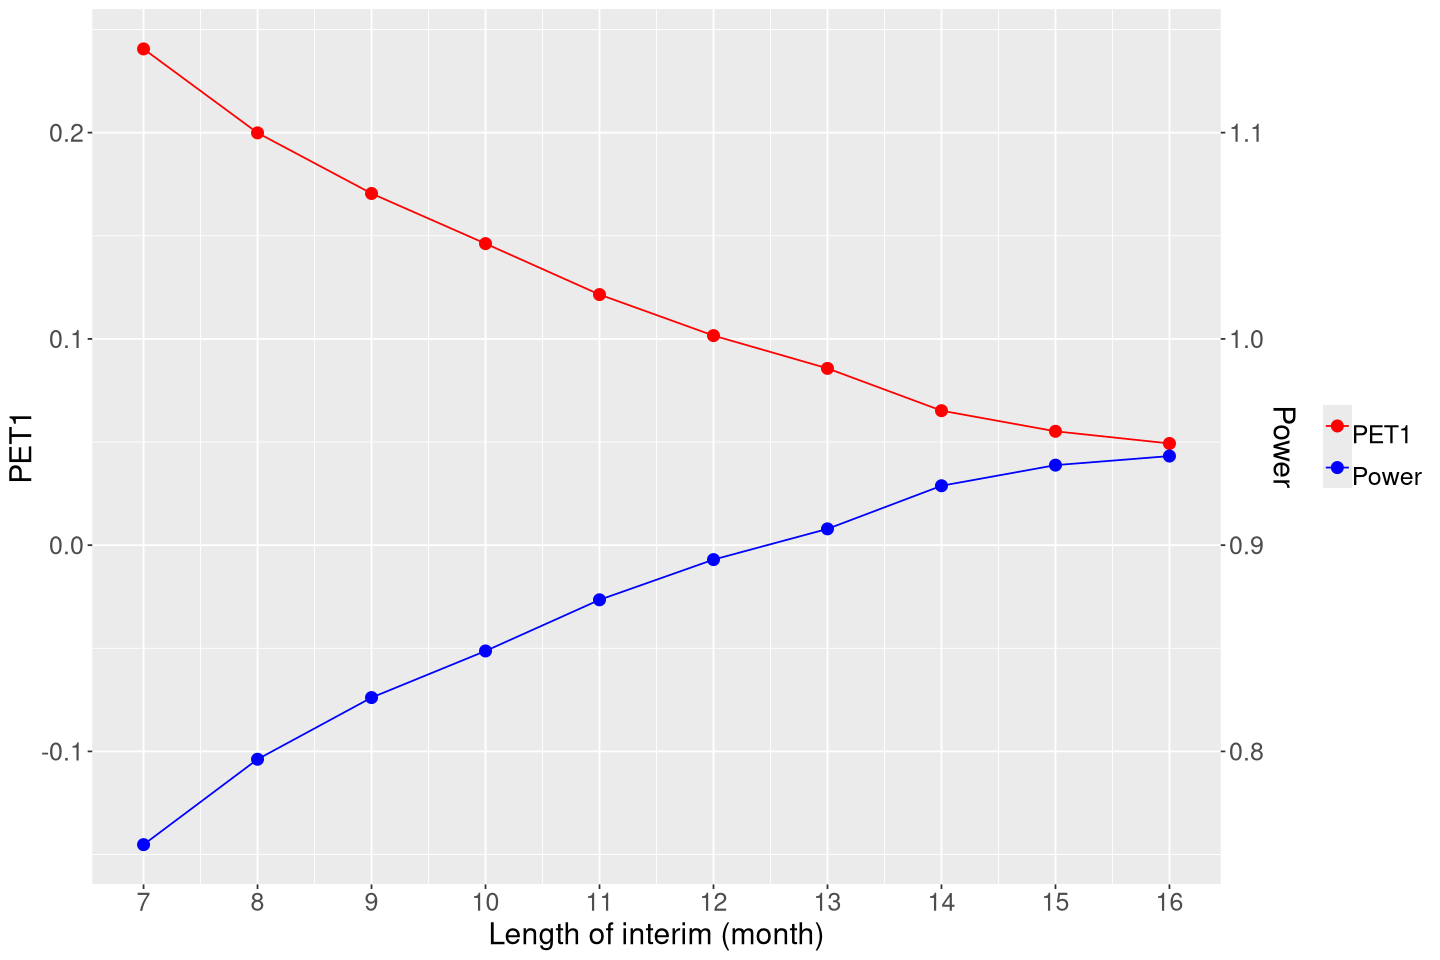

In [32]:
diff_interim_result$"interim_month" <- 7:16
df <- diff_interim_result
options(repr.plot.width = 12, repr.plot.height = 8)

plot_n1 <- ggplot(df) +
  geom_point(data = df, aes(x = interim_month, y = PET1, color = "PET1") ,size = 3) +
  geom_point(data = df, aes(x = interim_month, y = Power - 0.9, color = "Power") ,size = 3) +
  geom_line(data = df, aes(x = interim_month, y = PET1, color = "PET1")) +
  geom_line(data = df, aes(x = interim_month, y = Power - 0.9, color = "Power")) +
  scale_x_continuous(breaks = 7:16 ) +
  scale_y_continuous(name = "PET1", sec.axis = sec_axis(~ . + 0.9, name = "Power")) +
  scale_color_manual("Variable", values = c("PET1" = "red", "Power" = "blue")) +
  theme(legend.title = element_blank(),
         axis.title = element_text(size = 18, margin = margin(t = 20)),
         axis.text = element_text(size = 15,margin = margin(t = 10)),
         legend.text = element_text(size = 15,margin = margin(t = 10))) +
  guides(color = guide_legend(title = "Scales"))+
  labs(x = "Length of interim (month)", y = "PET1")

plot_n1
df

-------